## Configure PySpark Setup

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"


import findspark
findspark.init()


import pyspark 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("App").getOrCreate()
spark

In [2]:
# check number of cores PySpark is using
cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")

You are working with 1 core(s)


In [3]:
!cp /content/drive/MyDrive/Datasets.zip .
!unzip Datasets.zip

Archive:  Datasets.zip
   creating: Datasets/
  inflating: Datasets/fifa19.csv     
  inflating: Datasets/.DS_Store      
  inflating: Datasets/zomato.csv     
  inflating: Datasets/nyc_air_bnb.csv  
  inflating: Datasets/supermarket_sales.csv  
  inflating: Datasets/users3.parquet  
  inflating: Datasets/Toddler Autism dataset July 2018.csv  
   creating: Datasets/uw-madison-courses/
  inflating: Datasets/uw-madison-courses/course_offerings.csv  
  inflating: Datasets/uw-madison-courses/sections.csv  
  inflating: Datasets/uw-madison-courses/schedules.csv  
  inflating: Datasets/uw-madison-courses/database.sqlite3  
  inflating: Datasets/uw-madison-courses/rooms.csv  
  inflating: Datasets/uw-madison-courses/teachings.csv  
  inflating: Datasets/uw-madison-courses/subjects.csv  
  inflating: Datasets/uw-madison-courses/subject_memberships.csv  
  inflating: Datasets/uw-madison-courses/grade_distributions.csv  
  inflating: Datasets/uw-madison-courses/instructors.csv  
  inflating: Dat

# Load Libraries

In [33]:
from pyspark.ml.feature import *
from pyspark.sql.types import * 

from pyspark.sql.functions import col,lower,regexp_replace,udf,array_max
from pyspark.ml.clustering import LDA

import pandas as pd
import matplotlib.pyplot as plt

# ML Model Building

In [5]:
path = 'Datasets/'
df = spark.read.json(path+'recipes.json')

In [6]:
df.limit(5).toPandas()

,Author,Description,Ingredients,Method,Name,url
0,Mary Cadogan,Combine a few key Christmas flavours here to m...,"[2 tbsp olive oil, knob butter, 1 onion, finel...",[Heat oven to 190C/fan 170C/gas 5. Heat 1 tbsp...,Christmas pie,https://www.bbcgoodfood.com/recipes/2793/chris...
1,Mary Cadogan,An easy-to-make alternative to traditional Chr...,"[175g butter, chopped, 200g dark muscovado sug...","[Put the butter, sugar, fruit, zests, juice an...",Simmer-&-stir Christmas cake,https://www.bbcgoodfood.com/recipes/1160/simme...
2,Sara Buenfeld,These beautiful and classy little cakes make l...,"[200g dark muscovado sugar, 175g butter, chopp...","[Tip the sugar, butter, dried fruit, whole che...",Christmas cupcakes,https://www.bbcgoodfood.com/recipes/72622/chri...
3,Paul Hollywood,Paul Hollywood's fruit rolls can be made ahead...,"[500g strong white flour, plus extra for dusti...",[Put the flour and 1 tsp salt into a large bow...,Christmas buns,https://www.bbcgoodfood.com/recipes/1803633/ch...
4,Barney Desmazery,"Made these for the second time today, and I ha...","[280g self-raising flour, 175g golden caster s...",[Heat oven to 190C/170 fan/gas 5 and line a 12...,Christmas cupcakes,https://www.bbcgoodfood.com/recipes/981634/chr...


In [7]:
df.printSchema()

root
 |-- Author: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Ingredients: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Method: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- Name: string (nullable = true)
 |-- url: string (nullable = true)



In [11]:
# Missing value check
def null_value_calc(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        if(nullRows > 0):
            temp = k,nullRows,(nullRows/numRows)*100
            null_columns_counts.append(temp)
    return(null_columns_counts)

null_columns_calc_list = null_value_calc(df)
spark.createDataFrame(null_columns_calc_list, ['Column_Name', 'Null_Values_Count','Null_Value_Percent']).show()

+-----------+-----------------+------------------+
|Column_Name|Null_Values_Count|Null_Value_Percent|
+-----------+-----------------+------------------+
|     Author|                6|0.3710575139146568|
|Description|              188|11.626468769325912|
+-----------+-----------------+------------------+



In [12]:
#drop missing values
df = df.na.drop(subset=["Description"])
df.count()

1429

In [13]:
df.select('Description').show(2,False)

+------------------------------------------------------------------------------------------------+
|Description                                                                                     |
+------------------------------------------------------------------------------------------------+
|Combine a few key Christmas flavours here to make a pie that both children and adults will adore|
|An easy-to-make alternative to traditional Christmas cakes which requires no beating            |
+------------------------------------------------------------------------------------------------+
only showing top 2 rows



In [16]:
# Removing anything that is not a letter
df_clean = df.withColumn("Description",lower(regexp_replace('Description', '[^A-Za-z ]+', ' ')))

# Remove multiple spaces (because we replaced punctuation with a space)
df_clean = df_clean.withColumn("Description",regexp_replace(col('Description'), ' +', ' '))

df_clean.select('Description').show(2,False)

+------------------------------------------------------------------------------------------------+
|Description                                                                                     |
+------------------------------------------------------------------------------------------------+
|combine a few key christmas flavours here to make a pie that both children and adults will adore|
|an easy to make alternative to traditional christmas cakes which requires no beating            |
+------------------------------------------------------------------------------------------------+
only showing top 2 rows



In [17]:
# creating NLP Processing Pipeline

# Tokenize
regex_tokenizer = RegexTokenizer(inputCol="Description", outputCol="words", pattern="\\W")
raw_words = regex_tokenizer.transform(df_clean)

# Remove Stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
words_df = remover.transform(raw_words)


# Count Vectorizer
cv = CountVectorizer(inputCol="filtered", outputCol="features")
cvmodel = cv.fit(words_df)

# Transform NLP Pipeline
df_vect = cvmodel.transform(words_df)

# View the new dataframe
df_vect.limit(2).toPandas()

,Author,Description,Ingredients,Method,Name,url,words,filtered,features
0,Mary Cadogan,combine a few key christmas flavours here to m...,"[2 tbsp olive oil, knob butter, 1 onion, finel...",[Heat oven to 190C/fan 170C/gas 5. Heat 1 tbsp...,Christmas pie,https://www.bbcgoodfood.com/recipes/2793/chris...,"[combine, a, few, key, christmas, flavours, he...","[combine, key, christmas, flavours, make, pie,...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Mary Cadogan,an easy to make alternative to traditional chr...,"[175g butter, chopped, 200g dark muscovado sug...","[Put the butter, sugar, fruit, zests, juice an...",Simmer-&-stir Christmas cake,https://www.bbcgoodfood.com/recipes/1160/simme...,"[an, easy, to, make, alternative, to, traditio...","[easy, make, alternative, traditional, christm...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


In [18]:
# determinng optimum number of topics k
kmax = 10

log_likelihood = []
perplexity = []

for k in range(2,kmax):
    lda = LDA(k=k, maxIter=10)
    model = lda.fit(df_vect)
    ll = model.logLikelihood(df_vect)
    lp = model.logPerplexity(df_vect)

    log_likelihood.append(ll)
    perplexity.append(lp)

Text(0, 0.5, 'Log Likelihood')

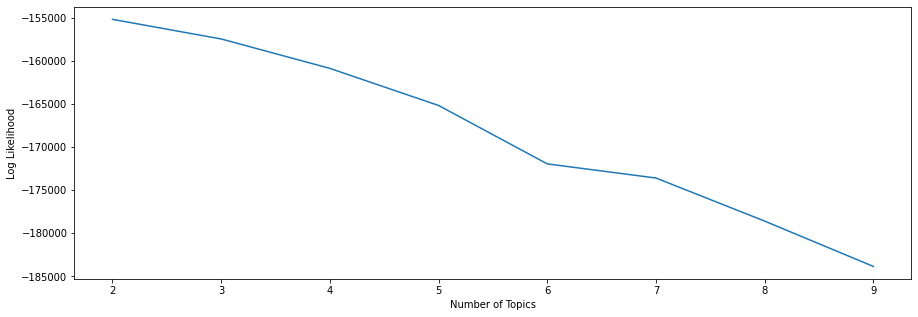

In [19]:
plt.figure(figsize=(15,5))
plt.plot(range(2,kmax),log_likelihood)
plt.xlabel('Number of Topics')
plt.ylabel("Log Likelihood")

Text(0, 0.5, 'Log Perplexity')

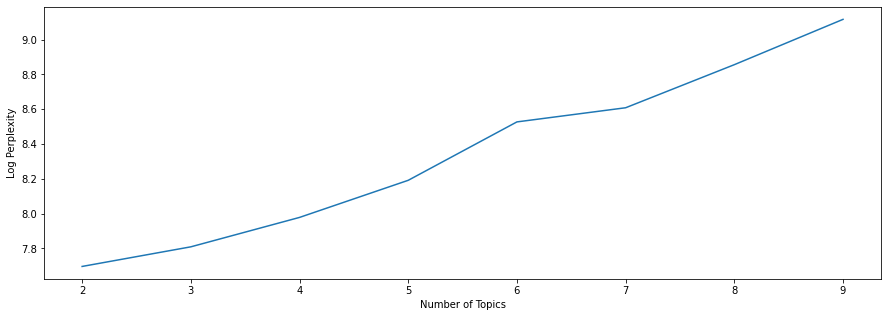

In [20]:
plt.figure(figsize=(15,5))
plt.plot(range(2,kmax),perplexity)
plt.xlabel('Number of Topics')
plt.ylabel("Log Perplexity")

In [21]:
# Trains a LDA model with k =3
lda = LDA(k=3, maxIter=10)
model = lda.fit(df_vect)

In [22]:
model.vocabSize()

3476

In [26]:
# describe topics
topics = model.describeTopics(maxTermsPerTopic = 6)
topics = topics.collect()
vocablist = cvmodel.vocabulary

for topic in topics:
    number, words, prob = topic
    prob = [round(num, 4) for num in prob]
    vocab = []
    for wrd in words:
        vocab.append(vocablist[wrd])
    words_dist = list(zip(vocab,prob))
    print(f'Topic: {number} :- {words_dist}')

Topic: 0 :- [('soda', 0.0024), ('cherry', 0.0017), ('free', 0.0014), ('want', 0.0013), ('club', 0.0012), ('sauce', 0.0012)]
Topic: 1 :- [('sprouts', 0.0025), ('christmas', 0.0023), ('day', 0.0021), ('really', 0.0021), ('individual', 0.0019), ('pastry', 0.0019)]
Topic: 2 :- [('christmas', 0.0103), ('make', 0.0093), ('recipe', 0.0062), ('dish', 0.0049), ('perfect', 0.0048), ('made', 0.0047)]


In [27]:
# Make predictions
transformed = model.transform(df_vect)
transformed.limit(3).toPandas()

,Author,Description,Ingredients,Method,Name,url,words,filtered,features,topicDistribution
0,Mary Cadogan,combine a few key christmas flavours here to m...,"[2 tbsp olive oil, knob butter, 1 onion, finel...",[Heat oven to 190C/fan 170C/gas 5. Heat 1 tbsp...,Christmas pie,https://www.bbcgoodfood.com/recipes/2793/chris...,"[combine, a, few, key, christmas, flavours, he...","[combine, key, christmas, flavours, make, pie,...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02814018230420405, 0.028853867333548482, 0...."
1,Mary Cadogan,an easy to make alternative to traditional chr...,"[175g butter, chopped, 200g dark muscovado sug...","[Put the butter, sugar, fruit, zests, juice an...",Simmer-&-stir Christmas cake,https://www.bbcgoodfood.com/recipes/1160/simme...,"[an, easy, to, make, alternative, to, traditio...","[easy, make, alternative, traditional, christm...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.032065956217971626, 0.032673107358480565, 0..."
2,Sara Buenfeld,these beautiful and classy little cakes make l...,"[200g dark muscovado sugar, 175g butter, chopp...","[Tip the sugar, butter, dried fruit, whole che...",Christmas cupcakes,https://www.bbcgoodfood.com/recipes/72622/chri...,"[these, beautiful, and, classy, little, cakes,...","[beautiful, classy, little, cakes, make, lovel...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.024935148272983695, 0.025649468888637367, 0..."


In [31]:
# Convert topicdistribution col from vector to array


# define udf
to_array = udf(lambda x: x.toArray().tolist(), ArrayType(DoubleType()))

recommendations = transformed.withColumn('array', to_array('topicDistribution'))
recommendations.limit(3).toPandas()

,Author,Description,Ingredients,Method,Name,url,words,filtered,features,topicDistribution,array
0,Mary Cadogan,combine a few key christmas flavours here to m...,"[2 tbsp olive oil, knob butter, 1 onion, finel...",[Heat oven to 190C/fan 170C/gas 5. Heat 1 tbsp...,Christmas pie,https://www.bbcgoodfood.com/recipes/2793/chris...,"[combine, a, few, key, christmas, flavours, he...","[combine, key, christmas, flavours, make, pie,...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02814018230420405, 0.028853867333548482, 0....","[0.02814018230420405, 0.028853867333548482, 0...."
1,Mary Cadogan,an easy to make alternative to traditional chr...,"[175g butter, chopped, 200g dark muscovado sug...","[Put the butter, sugar, fruit, zests, juice an...",Simmer-&-stir Christmas cake,https://www.bbcgoodfood.com/recipes/1160/simme...,"[an, easy, to, make, alternative, to, traditio...","[easy, make, alternative, traditional, christm...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.032065956217971626, 0.032673107358480565, 0...","[0.032065956217971626, 0.032673107358480565, 0..."
2,Sara Buenfeld,these beautiful and classy little cakes make l...,"[200g dark muscovado sugar, 175g butter, chopp...","[Tip the sugar, butter, dried fruit, whole che...",Christmas cupcakes,https://www.bbcgoodfood.com/recipes/72622/chri...,"[these, beautiful, and, classy, little, cakes,...","[beautiful, classy, little, cakes, make, lovel...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.024935148272983695, 0.025649468888637367, 0...","[0.024935148272983695, 0.025649468888637367, 0..."


In [34]:
# Find the best topic value that we will call "max"
max_vals = recommendations.withColumn("max",array_max("array"))
max_vals.limit(2).toPandas()

,Author,Description,Ingredients,Method,Name,url,words,filtered,features,topicDistribution,array,max
0,Mary Cadogan,combine a few key christmas flavours here to m...,"[2 tbsp olive oil, knob butter, 1 onion, finel...",[Heat oven to 190C/fan 170C/gas 5. Heat 1 tbsp...,Christmas pie,https://www.bbcgoodfood.com/recipes/2793/chris...,"[combine, a, few, key, christmas, flavours, he...","[combine, key, christmas, flavours, make, pie,...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02814018230420405, 0.028853867333548482, 0....","[0.02814018230420405, 0.028853867333548482, 0....",0.943006
1,Mary Cadogan,an easy to make alternative to traditional chr...,"[175g butter, chopped, 200g dark muscovado sug...","[Put the butter, sugar, fruit, zests, juice an...",Simmer-&-stir Christmas cake,https://www.bbcgoodfood.com/recipes/1160/simme...,"[an, easy, to, make, alternative, to, traditio...","[easy, make, alternative, traditional, christm...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.032065956217971626, 0.032673107358480565, 0...","[0.032065956217971626, 0.032673107358480565, 0...",0.935261


In [35]:
# Find the index of the max value found above which translates to our topic!
argmaxUdf = udf(lambda x,y: [i for i, e in enumerate(x) if e==y ])
results = max_vals.withColumn('topic', argmaxUdf(max_vals.array,max_vals.max))
results.limit(4).toPandas()

,Author,Description,Ingredients,Method,Name,url,words,filtered,features,topicDistribution,array,max,topic
0,Mary Cadogan,combine a few key christmas flavours here to m...,"[2 tbsp olive oil, knob butter, 1 onion, finel...",[Heat oven to 190C/fan 170C/gas 5. Heat 1 tbsp...,Christmas pie,https://www.bbcgoodfood.com/recipes/2793/chris...,"[combine, a, few, key, christmas, flavours, he...","[combine, key, christmas, flavours, make, pie,...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02814018230420405, 0.028853867333548482, 0....","[0.02814018230420405, 0.028853867333548482, 0....",0.943006,[2]
1,Mary Cadogan,an easy to make alternative to traditional chr...,"[175g butter, chopped, 200g dark muscovado sug...","[Put the butter, sugar, fruit, zests, juice an...",Simmer-&-stir Christmas cake,https://www.bbcgoodfood.com/recipes/1160/simme...,"[an, easy, to, make, alternative, to, traditio...","[easy, make, alternative, traditional, christm...","(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.032065956217971626, 0.032673107358480565, 0...","[0.032065956217971626, 0.032673107358480565, 0...",0.935261,[2]
2,Sara Buenfeld,these beautiful and classy little cakes make l...,"[200g dark muscovado sugar, 175g butter, chopp...","[Tip the sugar, butter, dried fruit, whole che...",Christmas cupcakes,https://www.bbcgoodfood.com/recipes/72622/chri...,"[these, beautiful, and, classy, little, cakes,...","[beautiful, classy, little, cakes, make, lovel...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.024935148272983695, 0.025649468888637367, 0...","[0.024935148272983695, 0.025649468888637367, 0...",0.949415,[2]
3,Paul Hollywood,paul hollywood s fruit rolls can be made ahead...,"[500g strong white flour, plus extra for dusti...",[Put the flour and 1 tsp salt into a large bow...,Christmas buns,https://www.bbcgoodfood.com/recipes/1803633/ch...,"[paul, hollywood, s, fruit, rolls, can, be, ma...","[paul, hollywood, fruit, rolls, made, ahead, h...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.022092430533715696, 0.022461809075314886, 0...","[0.022092430533715696, 0.022461809075314886, 0...",0.955446,[2]
